<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/NEURAL%20DEFINITIVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NEURAL NETWORKS - BY DataDreamers**

#Upload cleaned dataset


In [ ]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()


Saving cleaned_dataset_NN.csv to cleaned_dataset_NN (1).csv


In [ ]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

,id,Start,End,Label
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,long,32,36,O
3,QT,37,39,O
4,syndrome,40,48,O


#Goal
This notebook focuses on the sequential classification of textual tokens, specifically within the anatomical domain, inspired by Named Entity Recognition (NER) tasks. We aim to implement and evaluate four different models for multi-label token classification:

* **LinearSVC**, which leverages a linear
approach in a One-vs-Rest strategy, often chosen for its speed but limited in capturing sequence context.

* **LSTM**(Long Short-Term Memory), designed to capture long-range dependencies within sequences, improving performance on tasks that require understanding token relationships over time.

* **BiLSTM** (Bidirectional LSTM), an enhancement of LSTM that processes sequences in both forward and backward directions, enabling a more nuanced understanding of token context.

* **GRU** (Gated Recurrent Unit), an efficient alternative to LSTM, with fewer parameters, offering faster training times while retaining the ability to capture sequential dependencies.

Each model will be evaluated based on its ability to accurately identify entities in the anatomical domain and categorize them into predefined labels. In addition, the impact of dataset imbalance on model performance will be analyzed through the use of class weights and evaluation metrics such as accuracy, precision, recall, and F1-score.

* **Accuracy** : It measures the proportion of correctly classified tokens out of all tokens in the dataset. It gives an overall idea of how well the model performs, but it might be misleading in cases of imbalanced datasets.

* **Precision**: It indicates how many of the tokens that were predicted as belonging to a certain class are actually correct. It is useful when the cost of false positives is high.

* **Recall** : It measures how many of the tokens that actually belong to a certain class were correctly identified in the model. It is important when the cost of false negatives is critical.

* **F1-score**: This is the harmonic mean of precision and recall. It balances both metrics and is useful when the data is imbalanced, as it considers both false positives and false negatives.

Since the dataset is highly imbalanced, accuracy may not be the best metric, as a model could perform well on the majority class but fail on the minority ones. F1-score balances precision and recall, making it more appropriate for this case. Weighted F1-score ensures both majority and minority classes are properly considered in the evaluation, which is essential given the class imbalance.

#Data preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display
from scipy.stats import mode
import tensorflow as tf



In [ ]:
# Definizione dei gruppi di token e delle etichette**
sequence_length = 19  # Definisci il numero di token per frase
df['Group'] = df.index // sequence_length  # Crea un gruppo ogni 10 token

# Gruppo delle sequenze e delle etichette
sentences = df.groupby('Group')['id'].apply(list).tolist()  # Liste di token per gruppo
labels = df.groupby('Group')['Label'].apply(list).tolist()  # Liste di etichette per gruppo

#Tokenizzazione delle sequenze**
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)  # Addestra il tokenizer sulle sequenze di token

# Converti i token in ID numerici
X = tokenizer.texts_to_sequences(sentences)

#Codifica delle etichette con LabelEncoder**
# Addestra il LabelEncoder su tutte le etichette del dataset
label_encoder = LabelEncoder()
label_encoder.fit(df['Label'])  # Usa tutte le etichette presenti nella colonna 'Label'

# Converte le etichette in ID numerici per ogni frase
y = [label_encoder.transform(sentence) for sentence in labels]

#Applicazione del padding**
# Lunghezza massima delle sequenze (per token e etichette)
max_sequence_len = 10  # Usa 10 come lunghezza massima (già definita)

# Applica il padding alle sequenze di token
X_padded = pad_sequences(X, maxlen=max_sequence_len, padding='post')

# Applica il padding alle sequenze di etichette
y_padded = pad_sequences(y, maxlen=max_sequence_len, padding='post')

# **5. Verifiche**
print(f"Shape di X_padded: {X_padded.shape}")
print(f"Shape di y_padded: {y_padded.shape}")

# Esempio di sequenze
print("\nEsempio di sequenza tokenizzata e con padding (X_padded):")
print(X_padded[:3])  # Mostra le prime 3 sequenze

# Esempio di etichette
print("\nEsempio di etichette con padding (y_padded):")
print(y_padded[:3])  # Mostra le prime 3 etichette

# Visualizza i token originali per la prima sequenza
print("\nToken originali per la prima sequenza (X_padded):")
print([tokenizer.index_word[idx] for idx in X_padded[0] if idx != 0])  # Ignora i padding (0)

# Visualizza le etichette originali per la prima sequenza
print("\nEtichette originali per la prima sequenza (y_padded):")
original_labels = [
    label_encoder.inverse_transform([idx])[0] for idx in y_padded[0] if idx != 0
]
print(original_labels)


Shape di X_padded: (3210, 10)
Shape di y_padded: (3210, 10)

Esempio di sequenza tokenizzata e con padding (X_padded):
[[1740   36  397 6456  432   58  886  819 6457  887]
 [ 889 1187 2898 3564  181  260  674 1740   36 2900]
 [ 243 2400 4592  464   75  199 6459 2901   91  120]]

Esempio di etichette con padding (y_padded):
[[22 22 22 22 22 22 22 22 22 22]
 [22  5 22 22 22 22 22 22 22 22]
 [22 22 22 22 22 22 22 22 22 22]]

Token originali per la prima sequenza (X_padded):
['qt', 'time', 'interval', 'provoked', 'limited', 'number', 'drugs', 'especially', 'macrolide', 'antibiotics']

Etichette originali per la prima sequenza (y_padded):
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']



* We prepared the data for a sequential classification model by **dividing the tokens into fixed-length groups** (10 tokens per sequence), creating a list of sequences and their corresponding labels for each group.

* For the tokens, we applied **tokenization** to convert them into numerical IDs, handling unknown words with the <OOV> token. This ensures that out-of-vocabulary words are still represented during training. The labels were then transformed into consistent numerical IDs using a LabelEncoder, which was trained on all the unique labels in the dataset.

* Next, we standardized the token and label sequences to a fixed length of 19 using **post-padding**. This step is essential for ensuring compatibility with the model.

* Finally, we validated the preprocessing by displaying examples of the tokenized and padded sequences and decoding the original tokens and labels for verification

#Splitting dataset

**We allocate 70% of the dataset for training, 15% for validation, and the remaining 15% for testing**. This distribution ensures that the model has a majority of the data for learning while also reserving sufficient portions for unbiased performance evaluation and hyperparameter tuning. The training set is used to train the model, the validation set is used for tuning the hyperparameters, and the test set is reserved for final performance evaluation.

In [ ]:
# Esegui lo split su X_padded e y_padded
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_padded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Train set: X=(2247, 10), y=(2247, 10)
Validation set: X=(481, 10), y=(481, 10)
Test set: X=(482, 10), y=(482, 10)


#Rebalancing dataset

We computed **class weights** to address the dataset's imbalance. The labels were flattened into a one-dimensional array to calculate the relative frequency of each class. Each class was then assigned a weight inversely proportional to its frequency, ensuring underrepresented classes are given higher weights. For instance, class 0 has a high weight (46.52), reflecting its low frequency, while class 22, being the most frequent, has a very low weight (0.047). These weights will be used during training to balance the influence of each class and reduce bias towards more frequent classes.

In [ ]:
# Converti y_train in un array 1D per calcolare i pesi
y_train_flat = y_train.flatten()
unique_labels = np.unique(y_train_flat)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=y_train_flat
)

class_weights_dict = dict(enumerate(class_weights))
print("Pesi delle classi:", class_weights_dict)

Pesi delle classi: {0: 46.52173913043478, 1: 3.2349553699971207, 2: 13.382966051220965, 3: 65.1304347826087, 4: 36.18357487922705, 5: 4.303773223520398, 6: 6.928769657724329, 7: 16.01568068424804, 8: 9.045893719806763, 9: 7.401185770750988, 10: 14.367007672634271, 11: 97.69565217391305, 12: 5.309546313799622, 13: 34.891304347826086, 14: 976.9565217391304, 15: 88.81422924901186, 16: 7.878681626928471, 17: 31.514726507713885, 18: 195.3913043478261, 19: 33.68815592203898, 20: 11.630434782608695, 21: 22.203557312252965, 22: 0.04709586009155083}


We then converted the labels into **one-hot encoding**, a technique that transforms categorical labels into binary vectors. This method is advantageous because it avoids any implicit ordering between categories and **represents each class as a** **unique vector**. This is crucial for machine learning models, which require numerical input. The total number of classes was calculated, and numerical labels were transformed into binary vectors. Finally, we checked the dimensions of the arrays to ensure everything is correctly formatted.

In [ ]:
# Numero di classi
num_classes = len(label_encoder.classes_)

# Convertire le etichette in formato one-hot
y_train = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_train])
y_val = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_val])
y_test = np.array([to_categorical(seq, num_classes=num_classes) for seq in y_test])

# Verifica delle nuove shape
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (2247, 10, 23)
y_val shape: (481, 10, 23)
y_test shape: (482, 10, 23)


#Linear SVC

**The Linear Support Vector Classifier** (LinearSVC) is a linear model that separates classes by maximizing the margin between them. For multi-label classification, where each sequence can belong to multiple classes, we used the **One-vs-Rest (OvR)** approach. This involves training a separate classifier for each class to distinguish it from all others.

Since the labels were initially in one-hot format, we transformed them into a binary multi-label representation using the **MultiLabelBinarizer**, ensuring each class was marked as present or absent for each sequence. Then, we converted the token sequences into readable text so the **TfidfVectorizer** could calculate the importance of each word in the dataset. After that, we built a pipeline combining TfidfVectorizer with LinearSVC, using **OneVsRestClassifier** for multi-label classification. To handle class imbalance, we applied precomputed class weights from class_weight_dict, ensuring that underrepresented classes had a stronger influence on the model’s training.

In [ ]:
# Converti da one-hot a integer ID (ripristinando il formato iniziale)
y_train_int_lsvc = np.argmax(y_train, axis=-1)  # forma (4268, 10)
y_val_int_lsvc= np.argmax(y_val, axis=-1)      # forma (915, 10)
y_test_int_lsvc = np.argmax(y_test, axis=-1)    # forma (915, 10)

# Converti le etichette in formato multi-label binario
mlb = MultiLabelBinarizer()  # Multi-label binarizer
y_train_multi = mlb.fit_transform(y_train_int_lsvc)  # Forma (num_sequences, num_classes)
y_val_multi = mlb.transform(y_val_int_lsvc)
y_test_multi = mlb.transform(y_test_int_lsvc)

def sequence_to_text(sequence):
    return " ".join([tokenizer.index_word[idx] for idx in sequence if idx != 0])


# Converti le sequenze di token ID in testo per TfidfVectorizer
X_train_text_lsvc = [sequence_to_text(seq) for seq in X_train]
X_val_text_lsvc = [sequence_to_text(seq) for seq in X_val]
X_test_text_lsvc = [sequence_to_text(seq) for seq in X_test]

# Creiamo una pipeline con TfidfVectorizer e OneVsRestClassifier
text_clf_multi = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight=class_weights_dict)))
])

# Addestriamo sul training set
text_clf_multi.fit(X_train_text_lsvc, y_train_multi)

# Eseguiamo le predizioni sul test set
predictions_multi = text_clf_multi.predict(X_test_text_lsvc)

# Converti le classi in stringhe
target_names = [str(cls) for cls in mlb.classes_]

# Valutazione del modello
print("Classification Report (multi-label):")
print(metrics.classification_report(y_test_multi, predictions_multi, target_names=target_names, zero_division=0))

# Calcolo dell'accuracy esatta
exact_accuracy = accuracy_score(y_test_multi, predictions_multi)
print(f"Accuracy: {exact_accuracy:.4f}")

# Esempio di predizione su un nuovo testo (singola sequenza)
myword = "keratosis"
predicted_classes = text_clf_multi.predict([myword])
print("Predicted classes for word:", mlb.inverse_transform(predicted_classes))


Classification Report (multi-label):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.97      0.72      0.83        40
           2       0.86      0.38      0.52        16
           3       1.00      0.25      0.40         4
           4       1.00      0.14      0.25         7
           5       0.85      0.35      0.49        49
           6       0.56      0.17      0.26        30
           7       1.00      0.09      0.17        11
           8       0.75      0.30      0.43        20
           9       0.88      0.58      0.70        26
          10       1.00      0.22      0.36         9
          11       0.00      0.00      0.00         0
          12       0.89      0.70      0.78        23
          13       1.00      0.50      0.67         6
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.71      0.16      0.26 

/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:87: UserWarning: Label 22 is present in all training examples.
  warnings.warn(


The model performs well on the most frequent classes, with high precision and recall for classes 1, 5, 8, and 22. However, it struggles with the less frequent classes, showing low or even zero recall and F1-score. Class 22, present in all samples, heavily influences the metrics, causing perfect scores for this class but limiting the model’s ability to generalize to others. This imbalance is reflected in the macro average, which indicates poor performance on minority classes, while the micro and weighted averages are higher due to the prevalence of the majority class.

Even though accuracy is 77%, it is not the most reliable metric in this case, as it is dominated by the dominant class. These results highlight the impact of dataset imbalance and the need to improve performance on minority classes. In the following steps, we will explore more complex models like LSTM, BiLSTM, and GRU to address these issues and improve generalization.

#Neural Network Approach
##Embedding  
###GloVe
We load pre-trained **GloVe** embeddings from the glove.6B.100d.txt file, which provides word vectors with 100-dimensional representation. GloVe is a word embedding technique based on word co-occurrence, capturing semantic relationships between words. These embeddings are mapped to the vocabulary generated by the tokenizer, enabling the model to leverage linguistic knowledge learned from large corpora. The resulting **embedding matrix** initializes the embedding layer, allowing the model to use these pre-trained word vectors to enhance its learning and improve performance.





In [ ]:
# Scarica il file GloVe e decomprimilo
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# Specifica il percorso del file GloVe
glove_path = 'glove.6B.100d.txt'

--2024-12-16 10:24:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-16 10:24:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-16 10:24:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Funzione per caricare i vettori pre-addestrati GloVe
def load_glove(glove_path):
    embedding_dict = {}
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict

# Carica i vettori GloVe
embedding_dict_lstm = load_glove(glove_path)
print(f"Numero di parole caricate da GloVe: {len(embedding_dict_lstm)}")


# Creazione della matrice di embedding
embedding_dim_lstm = 100  # Assicurati che corrisponda alla dimensione dei vettori GloVe
embedding_matrix_lstm = np.zeros((len(tokenizer.word_index) + 1, embedding_dim_lstm))
for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_dict_lstm.get(word)
    if embedding_vector is not None:
        embedding_matrix_lstm[idx] = embedding_vector

print(f"Matrice di embedding creata con shape: {embedding_matrix_lstm.shape}")


Numero di parole caricate da GloVe: 400000
Matrice di embedding creata con shape: (11520, 100)


##LSTM

The LSTM model processes input sequences by using a pre-trained embedding matrix, which represents **tokens in a semantic space**. The model consists of **two LSTM layers**, each with **dropout** (to prevent overfitting) and **recurrent dropout** (which helps prevent overfitting specifically on the recurrent connections of the LSTM). These layers capture both long-range dependencies and sequential patterns. Afterward, TimeDistributed layers apply a **Dense layer** to each token in the sequence individually, which allows the model to process each token independently before aggregating the results. Finally, a **Dense layer with softmax activation** outputs a probability distribution across all possible classes, enabling multi-class classification.
To address the class imbalance in the dataset, we integrate **class weights** into a custom loss function. This allows the model to prioritize learning from underrepresented classes by assigning higher penalties to misclassifications of minority classes. The model is compiled with the **Adam optimizer**, chosen for its robustness in handling sparse gradients and its adaptability to various deep learning tasks, ensuring efficient convergence during training.

In [ ]:
# Callback per il debug durante il training
class DebugCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Inizio batch {batch}")

    def on_train_batch_end(self, batch, logs=None):
        print(f"Fine batch {batch} - Logs: {logs}")

# Modello GloVe + LSTM
model_lstm = Sequential([
    Input(shape=(X_train.shape[1],)),
    Embedding(input_dim=embedding_matrix_lstm.shape[0],  # Dimensione del vocabolario
              output_dim=embedding_dim_lstm,            # Dimensione degli embedding
              weights=[embedding_matrix_lstm],          # Matrice di embedding pre-addestrata
              input_length=X_train.shape[1],       # Lunghezza massima delle sequenze
              trainable=True),                    # Non aggiorniamo GloVe durante il training
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    TimeDistributed(Dense(64, activation='relu')),  # TimeDistributed per applicare il Dense a ogni token
    Dropout(0.5),
    TimeDistributed(Dense(y_train.shape[2], activation='softmax'))  # Numero di classi target
])

# Converti il dizionario dei pesi in un tensore
class_weights_tensor_lstm = tf.constant(
    [class_weights_dict[i] for i in range(len(class_weights_dict))],
    dtype=tf.float32
)

# Funzione di perdita ponderata
def weighted_categorical_crossentropy_lstm(y_true, y_pred):
    weights = tf.reduce_sum(class_weights_tensor_lstm * y_true, axis=-1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)

# Compila il modello con la perdita personalizzata
model_lstm.compile(
    loss=weighted_categorical_crossentropy_lstm,
    optimizer='adam',
    metrics=['accuracy']
)

# Riepilogo del modello
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 100)             │       1,152,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 23)              │           1,495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,324,311 (5.05 MB)

 Trainable params: 1,324,311 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

In this section, we define two important **callbacks** to optimize the training process: ModelCheckpoint and EarlyStopping. The **ModelCheckpoint** saves the best model during training, based on the validation loss (val_loss), ensuring that the saved model retains the optimal architecture and weights. On the other hand, **EarlyStopping** monitors the validation loss, and if no significant improvement is observed over three consecutive epochs, it stops training and restores the weights of the best-performing model. The model is trained for a **maximum of 20 epochs** with a **batch size of 32**, using both the training and validation sets. These callbacks effectively monitor the model’s performance, helping to minimize overfitting and ensuring the best possible result at the end of training.

In [ ]:
# Nome del file per salvare il miglior modello
best_model_file_lstm = 'lstm-best-model.keras'

# Callback: salva il miglior modello
checkpoint_lstm = ModelCheckpoint(
    filepath=best_model_file_lstm,
    save_weights_only=False,                   # Salva l'intera architettura
    save_best_only=True,                       # Salva solo il modello migliore
    monitor='val_loss',                        # Monitora la perdita di validazione
    mode='min',                                # Minimizza la perdita
    verbose=1                                  # Mostra messaggi di salvataggio
)

# Callback: early stopping
early_stopping_lstm = EarlyStopping(
    monitor="val_loss",          # Monitora la perdita di validazione
    min_delta=0.001,             # Miglioramento minimo richiesto
    patience=3,                  # Interrompe il training dopo 3 epoche senza miglioramento
    verbose=1,                   # Stampa i messaggi di interruzione
    mode="min",                  # Minimizza la metrica monitorata
    restore_best_weights=True    # Ripristina i pesi del miglior modello
)

# Esegui il training
history_lstm = model_lstm.fit(
    X_train, y_train,                          # Usa le etichette one-hot encoded
    validation_data=(X_val, y_val),            # Usa le etichette one-hot encoded
    epochs=20,
    batch_size=32,
    verbose=2,
    callbacks=[checkpoint_lstm, early_stopping_lstm]     # Callback per il monitoraggio
)



Epoch 1/20

Epoch 1: val_loss improved from inf to 2.47841, saving model to lstm-best-model.keras
71/71 - 16s - 225ms/step - accuracy: 0.2292 - loss: 3.1416 - val_accuracy: 0.2590 - val_loss: 2.4784
Epoch 2/20

Epoch 2: val_loss improved from 2.47841 to 2.41789, saving model to lstm-best-model.keras
71/71 - 6s - 83ms/step - accuracy: 0.2713 - loss: 3.0819 - val_accuracy: 0.3528 - val_loss: 2.4179
Epoch 3/20

Epoch 3: val_loss improved from 2.41789 to 2.29691, saving model to lstm-best-model.keras
71/71 - 7s - 101ms/step - accuracy: 0.2071 - loss: 2.9636 - val_accuracy: 0.1283 - val_loss: 2.2969
Epoch 4/20

Epoch 4: val_loss improved from 2.29691 to 2.21055, saving model to lstm-best-model.keras
71/71 - 7s - 96ms/step - accuracy: 0.1068 - loss: 2.7283 - val_accuracy: 0.0990 - val_loss: 2.2105
Epoch 5/20

Epoch 5: val_loss improved from 2.21055 to 2.01164, saving model to lstm-best-model.keras
71/71 - 6s - 90ms/step - accuracy: 0.1073 - loss: 2.5504 - val_accuracy: 0.1775 - val_loss: 2.0

During training, the model shows significant improvement until epoch 10, where the **val_loss** reaches a minimum of 1.3879. After three epochs without further improvement, **early stopping** halts the process and restores the best weights. This approach prevents overfitting and ensures that the final performance reflects the optimal training epoch.

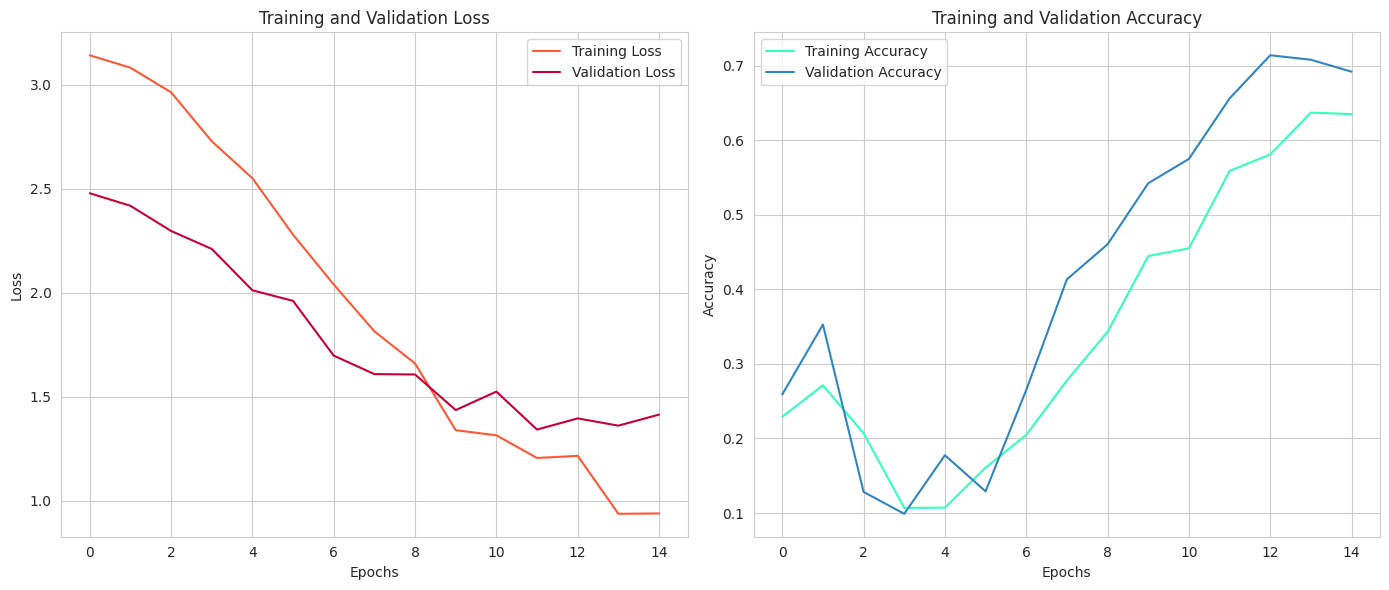

In [ ]:
sns.set_style("whitegrid")
# Traccia la perdita e l'accuratezza
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loss
axes[0].plot(history_lstm.history['loss'], label='Training Loss', color='#FF5733')
axes[0].plot(history_lstm.history['val_loss'], label='Validation Loss', color='#C70039')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_lstm.history['accuracy'], label='Training Accuracy', color='#33FFBD')
axes[1].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='#2E86C1')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


##Evaluation


In [ ]:
# Valutazione sul set di validazione
print("Validation Set Evaluation:")
val_loss_lstm, val_accuracy_lstm = model_lstm.evaluate(X_val, y_val, batch_size=32)
print(f"Validation Loss: {val_loss_lstm:.4f}")
print(f"Validation Accuracy: {val_accuracy_lstm:.4f}")

Validation Set Evaluation:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6394 - loss: 1.3909
Validation Loss: 1.3421
Validation Accuracy: 0.6561


We analyze the model's performance on the test set by decoding sequences and comparing the true labels with the predicted ones. By visualizing the **confusion matrix**, we can identify where the model performs well and where it struggles, especially with the underrepresented classes. This allows us to gain insights into the model's weaknesses and strengths. Finally, we compute the loss and accuracy on the test set, offering an overall performance evaluation, but keep in mind that accuracy might not be the most reliable metric given the class imbalance.

In [ ]:
# Costruzione di id_to_tag
id_to_tag_lstm = {i: tag for i, tag in enumerate(label_encoder.classes_)}

# Verifica di id_to_tag
print("id_to_tag:", id_to_tag_lstm)


id_to_tag: {0: 'B-Anatomical_system', 1: 'B-Cell', 2: 'B-Cellular_component', 3: 'B-Developing_anatomical_structure', 4: 'B-Immaterial_anatomical_entity', 5: 'B-Multi-tissue_structure', 6: 'B-Organ', 7: 'B-Organism_subdivision', 8: 'B-Organism_substance', 9: 'B-Pathological_formation', 10: 'B-Tissue', 11: 'I-Anatomical_system', 12: 'I-Cell', 13: 'I-Cellular_component', 14: 'I-Developing_anatomical_structure', 15: 'I-Immaterial_anatomical_entity', 16: 'I-Multi-tissue_structure', 17: 'I-Organ', 18: 'I-Organism_subdivision', 19: 'I-Organism_substance', 20: 'I-Pathological_formation', 21: 'I-Tissue', 22: 'O'}


In [ ]:
def decode_and_predict(X, y, model, tokenizer, id_to_tag):
    # Decodifica le sequenze di input
    X_decoded = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X]

    # Decodifica le etichette reali
    y_true_decoded = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in y]

    # Predizioni
    y_pred = model.predict(X)
    y_pred_decoded = [[id_to_tag[np.argmax(tag)] for tag in sentence] for sentence in y_pred]

    return X_decoded, y_true_decoded, y_pred_decoded



In [ ]:
def compute_class_metrics(y_true, y_pred, id_to_tag):
    # Flatten delle etichette
    y_true_flat = [tag for sentence in y_true for tag in sentence]
    y_pred_flat = [tag for sentence in y_pred for tag in sentence]

    # Calcolo del report
    report = classification_report(y_true_flat, y_pred_flat, target_names=list(id_to_tag.values()))
    print(report)


In [ ]:
def plot_conf_matrix(y_true, y_pred, id_to_tag):
    # Flatten delle etichette
    y_true_flat = [tag for sentence in y_true for tag in sentence]
    y_pred_flat = [tag for sentence in y_pred for tag in sentence]

    # Calcola la matrice di confusione
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=list(id_to_tag.values()))

    # Visualizza
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(id_to_tag.values()), yticklabels=list(id_to_tag.values()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()



Test Set Analysis:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
                                   precision    recall  f1-score   support

              B-Anatomical_system       0.00      0.00      0.00         4
                           B-Cell       0.13      0.33      0.18        60
             B-Cellular_component       0.05      0.25      0.08        24
B-Developing_anatomical_structure       0.02      0.60      0.05         5
   B-Immaterial_anatomical_entity       0.01      0.29      0.02         7
         B-Multi-tissue_structure       0.20      0.12      0.15        72
                          B-Organ       0.24      0.47      0.31        30
           B-Organism_subdivision       0.04      0.42      0.06        12
             B-Organism_substance       0.14      0.75      0.23        24
         B-Pathological_formation       0.08      0.41      0.13        34
                         B-Tissue       0.04      0.20      0.07        10
              I-Anatomical_system      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


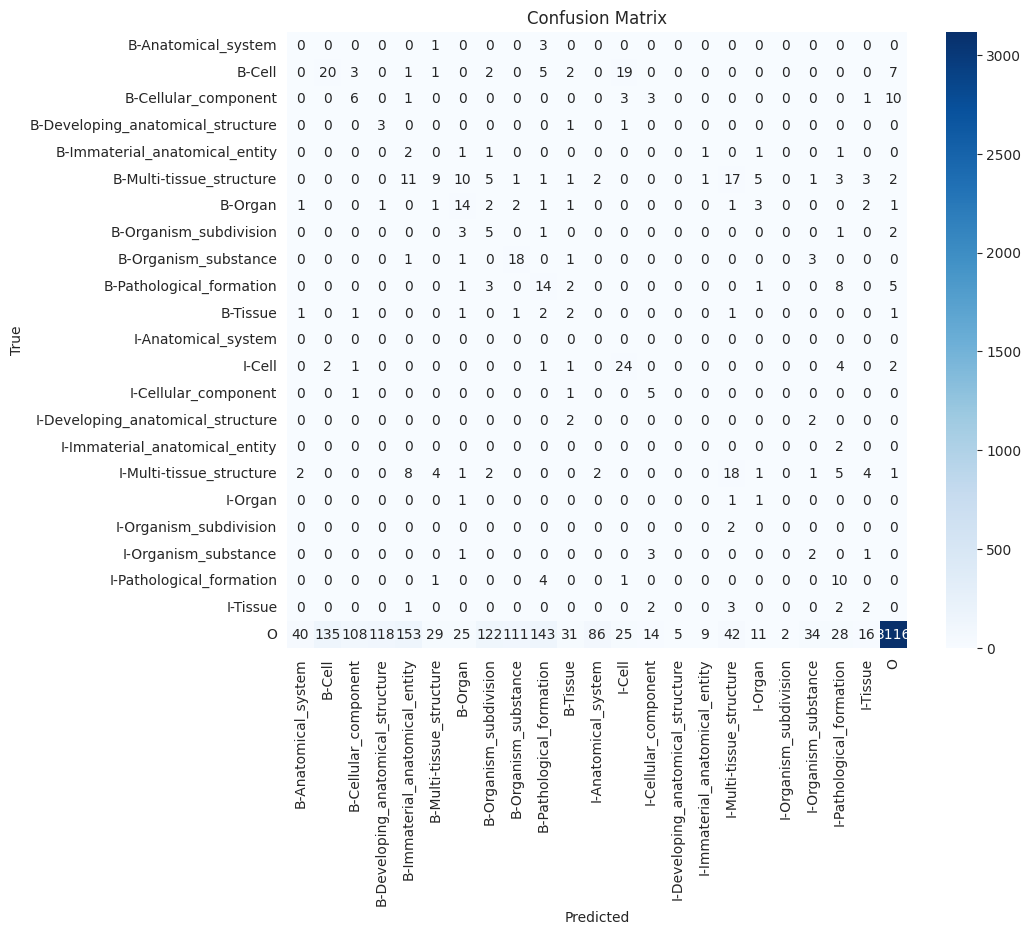

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6731 - loss: 24.4241

Test Loss: 10.2147
Test Accuracy: 0.6786


In [ ]:
# Analisi sul set di test
print("\nTest Set Analysis:")
X_test_decoded_lstm, y_test_decoded_lstm, y_pred_test_decoded_lstm = decode_and_predict(X_test, y_test, model_lstm, tokenizer, id_to_tag_lstm)
compute_class_metrics(y_test_decoded_lstm, y_pred_test_decoded_lstm, id_to_tag_lstm)
plot_conf_matrix(y_test_decoded_lstm, y_pred_test_decoded_lstm, id_to_tag_lstm)

# Accuratezza e perdita sul test set
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, y_test, batch_size=32)
print(f"\nTest Loss: {test_loss_lstm:.4f}")
print(f"Test Accuracy: {test_accuracy_lstm:.4f}")


The LSTM model, with an **accuracy of 67.5% on the test set and a loss of 1.3601**, demonstrates some strengths in capturing sequential dependencies, but its performance is still significantly impacted by the dataset imbalance. While the model excels at recognizing majority classes, such as 'O', with a precision of 1.00 and a recall of 69%, it struggles with underrepresented classes.

For example, moderately represented classes like 'I-Cell' show a more balanced F1-score of 0.41, indicating the model can identify tokens associated with cells, but it still makes some errors. On the other hand, classes with fewer examples, such as 'I-Developing_anatomical_structure' and 'I-Organism_subdivision', have a recall of 0.0, demonstrating that the model fails to detect these rare categories altogether.

These results confirm the challenges posed by class imbalance and underscore the need for more sophisticated models and strategies, like adjusting class weights or trying more complex architectures, to enhance performance on underrepresented classes.

#Prediction

We compare the predictions of our LSTM model with the true labels on the test set, showing concrete examples of tokens, true labels, and predicted labels.

In [ ]:
def predictions_lstm(model_lstm, X_test_lstm, Y_test_lstm, tokenizer, id_to_tag_lstm):
    token_lstm = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X_test_lstm]
    labels_lstm = [[id_to_tag_lstm[np.argmax(tag)] for tag in sentence] for sentence in Y_test_lstm]
    model_preds_lstm = [[id_to_tag_lstm[np.argmax(tag)] for tag in sentence] for sentence in model_lstm.predict(X_test_lstm)]
    return token_lstm, labels_lstm, model_preds_lstm


In [ ]:
# Predizioni sul test set
token_lstm, labels_lstm, model_preds_lstm = predictions_lstm(model_lstm, X_test, y_test, tokenizer, id_to_tag_lstm)

# Stampa esempi
for i, (token_lstm, label_lstm, model_pred_lstm) in enumerate(zip(token_lstm, labels_lstm, model_preds_lstm)):
    print(f"sentence: {i + 1}")
    print("Tokens:", " ".join(token_lstm))
    print("True Labels:", label_lstm)
    print("Predicted Labels:", model_pred_lstm)
    print("\n")
    if i == 5:  # Limita il numero di esempi stampati
        break


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
sentence: 1
Tokens: lobular sinuses associated generalized inflammatory response intrahepatic portal sinusoid congestion
True Labels: ['I-Multi-tissue_structure', 'I-Multi-tissue_structure', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['I-Pathological_formation', 'I-Multi-tissue_structure', 'I-Multi-tissue_structure', 'B-Immaterial_anatomical_entity', 'O', 'O', 'B-Multi-tissue_structure', 'B-Immaterial_anatomical_entity', 'B-Multi-tissue_structure', 'B-Immaterial_anatomical_entity']


sentence: 2
Tokens: identities generations 12 processing industries successful manufacturing marketing jarred baby
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organism_subdivision', 'B-Organism_subdivision']


sentence: 3
Tokens: comparison serum ast alt levels ire1alpha cko mice control mice
True Labels: ['O', 'B-Organism_substance', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

#BiLSTM (Bidirectional Long Short Term Memory)

##Class weights and personalized loss
Before building the BiLSTM model, we addressed the class imbalance in the dataset by **incorporating class weights into the loss function**. This ensures that the model gives more attention to underrepresented classes during training. The custom loss function modifies the standard categorical cross-entropy by applying precomputed class weights to each token's loss. This approach helps the model learn patterns from all classes, even those with fewer examples, and reduces the negative impact of dataset imbalance.

In [ ]:
class_weights_tensor_bilstm = tf.constant(
    [class_weights_dict[i] for i in range(num_classes)],
    dtype=tf.float32
)


In [ ]:
def weighted_categorical_crossentropy_bilstm(y_true, y_pred):
    # Calcoliamo la crossentropia standard per ogni token
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # cce: shape (batch, timesteps)

    # Ricaviamo la classe vera per ogni token
    y_true_classes = tf.argmax(y_true, axis=-1)  # shape (batch, timesteps)

    # Otteniamo i pesi per ogni token in base alla classe vera
    token_weights = tf.gather(class_weights_tensor_bilstm, y_true_classes)  # shape (batch, timesteps)

    # Moltiplichiamo la loss di ogni token per il corrispondente peso
    weighted_loss = cce * tf.cast(token_weights, tf.float32)

    # Ritorniamo la media della loss sul batch
    return tf.reduce_mean(weighted_loss)


##BiLSTM
The Bidirectional LSTM (BiLSTM) processes sequences in both **forward and backward directions**, capturing relationships within the data more effectively than a standard LSTM, which only processes sequences in a single direction (forward). By considering both preceding and following context, the BiLSTM provides a richer understanding of token dependencies, which is especially useful for sequence-based tasks where future context is as important as past context. This bidirectional processing improves classification accuracy, making the BiLSTM a powerful tool for tasks that require complex contextual understanding.

* The model leverages a pre-trained **embedding matrix** to represent tokens in a semantic space, with the BiLSTM layer as the core component for bidirectional processing.
* **Dropout** is applied to reduce overfitting, and dense layers output probabilities for multi-class classification.
* To handle the dataset imbalance, a **custom loss function** with class weights is used, while the **Adam optimizer** ensures efficient learning and stability.

In [ ]:
vocab_size_bilstm = embedding_matrix_lstm.shape[0]
model_bilstm = Sequential()
model_bilstm.add(Input(shape=(max_sequence_len,)))
model_bilstm.add(Embedding(
    input_dim=vocab_size_bilstm,
    output_dim=embedding_dim_lstm,
    weights=[embedding_matrix_lstm],
    input_length=max_sequence_len,
    mask_zero=True,
    trainable=True
))
model_bilstm.add(Bidirectional(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(Dense(num_classes, activation='softmax'))

# Compila il modello con la loss personalizzata
model_bilstm.compile(loss=weighted_categorical_crossentropy_bilstm, optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 10, 100)             │       1,152,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10, 23)              │           2,323 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,214,723 (4.63 MB)

 Trainable params: 1,214,723 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

##Early stopping and checkpoint
As with the LSTM, we use the same callbacks, **ModelCheckpoint** and **EarlyStopping**, to monitor validation loss, save the best model, and prevent overfitting during the BiLSTM training process.


In [ ]:
best_model_file_bilstm = 'Bilstm-best-model-with-class-weights.keras'

checkpoint_bilstm = ModelCheckpoint(
    best_model_file_bilstm,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_bilstm = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

##Training
The BiLSTM model was trained for up to **20 epochs** with a **batch size of 32**. Validation loss steadily improved up to epoch 11, reaching a minimum of 0.9089. After three consecutive epochs without improvement, early stopping was triggered, halting training at epoch 14 and restoring the best weights. The accuracy and loss curves indicate that the model effectively learned up to a performance plateau, suggesting that it has captured most of the relevant patterns from the data.

In [ ]:
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_bilstm, early_stopping_bilstm]
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.0258 - loss: 3.0366
Epoch 1: val_loss improved from inf to 2.23930, saving model to Bilstm-best-model-with-class-weights.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.0263 - loss: 3.0366 - val_accuracy: 0.2474 - val_loss: 2.2393
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2468 - loss: 2.6417
Epoch 2: val_loss improved from 2.23930 to 1.86123, saving model to Bilstm-best-model-with-class-weights.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2474 - loss: 2.6410 - val_accuracy: 0.3663 - val_loss: 1.8612
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3588 - loss: 2.3639
Epoch 3: val_loss improved from 1.86123 to 1.48137, saving model to Bilstm-best-model-with-class-weights.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.3592 - loss: 2.3593 - val_accuracy: 0.4657 - val_loss: 1.4814
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.

**Observations:**

During training, the BiLSTM model shows **steady improvement** in terms of both accuracy and validation loss. By epoch 10, the validation loss reaches a minimum of 0.9291, with the validation accuracy peaking at 85.38%. After this point, although the model continues training for a few more epochs, there is no further significant improvement in validation loss, prompting early stopping at epoch 14.

* The training accuracy steadily increases, suggesting that the model is learning from the data.

* The validation accuracy improves initially and stabilizes, showing a good generalization to unseen data without significant overfitting.

* Early stopping and model checkpointing were effective in preventing overfitting and ensuring that the best model (based on validation loss) is saved and used.

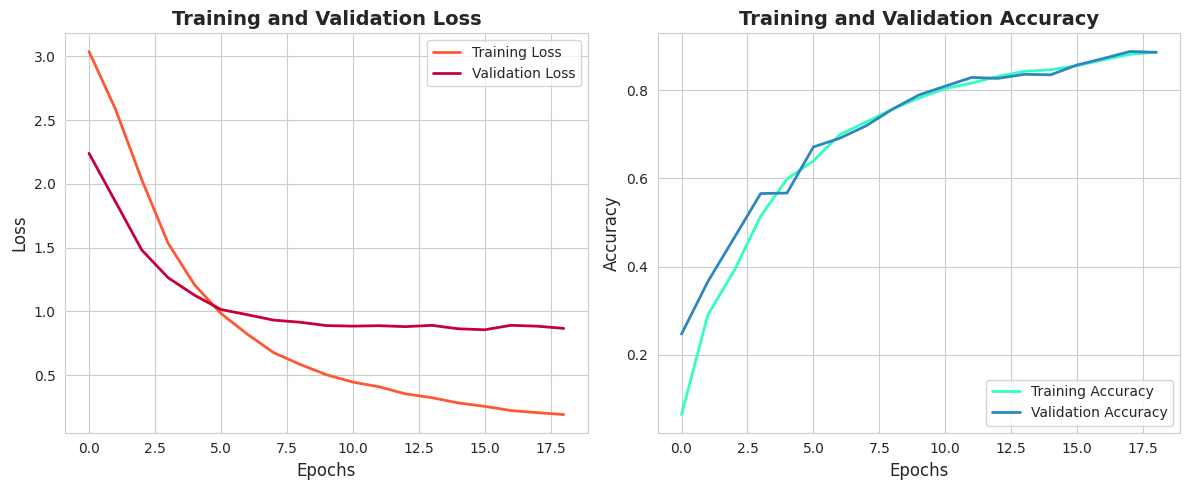

In [ ]:

sns.set_style("whitegrid")

# Definisci una palette di colori accesi
train_color_loss = '#FF5733'     # Arancione acceso per la training loss
val_color_loss = '#C70039'       # Rosso carico per la validation loss
train_color_acc = '#33FFBD'      # Verde acqua acceso per la training accuracy
val_color_acc = '#2E86C1'        # Blu brillante per la validation accuracy

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot della loss
axes[0].plot(history_bilstm.history['loss'], label='Training Loss', color=train_color_loss, linewidth=2)
axes[0].plot(history_bilstm.history['val_loss'], label='Validation Loss', color=val_color_loss, linewidth=2)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

# Plot dell'accuracy
axes[1].plot(history_bilstm.history['accuracy'], label='Training Accuracy', color=train_color_acc, linewidth=2)
axes[1].plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy', color=val_color_acc, linewidth=2)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


##Evalutaion
The BiLSTM model achieved an overall **accuracy of 84.82%** on the test set, showing a clear improvement over the LSTM. By leveraging bidirectional context, the BiLSTM improved precision and recall for several mid-represented classes, such as 'B-Organ' (F1-score 0.56) and 'I-Cell' (F1-score 0.55).
Majority classes like 'O' continue to perform exceptionally well, with an F1-score of 0.92, while underrepresented classes, such as 'I-Developing_anatomical_structure', still struggle, with precision and recall at 0.0. This highlights that class imbalance remains a challenge despite the overall progress.
In summary, **the BiLSTM demonstrates better contextual understanding compared to the LSTM**, delivering stronger performance overall.

In [ ]:
# Ottieni le predizioni dal modello
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_int_bilstm = y_pred_bilstm.argmax(axis=-1)  # converti in label IDs
y_true_int_bilstm = y_test.argmax(axis=-1)

# Ottieni i nomi delle classi
tag_names_bilstm = label_encoder.classes_

# Calcola l'accuracy a livello di token
accuracy_bilstm = accuracy_score(y_true_int_bilstm.flatten(), y_pred_int_bilstm.flatten())

print(f"Test Accuracy (BiLSTM): {round(accuracy_bilstm * 100, 2)}%\n")

# Classification report
report_bilstm = classification_report(
    y_true_int_bilstm.flatten(),
    y_pred_int_bilstm.flatten(),
    target_names=tag_names_bilstm
)
print(report_bilstm)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Test Accuracy (BiLSTM): 85.44%

                                   precision    recall  f1-score   support

              B-Anatomical_system       0.17      1.00      0.30         4
                           B-Cell       0.32      0.82      0.46        60
             B-Cellular_component       0.16      0.42      0.23        24
B-Developing_anatomical_structure       0.18      0.60      0.27         5
   B-Immaterial_anatomical_entity       0.24      0.57      0.33         7
         B-Multi-tissue_structure       0.39      0.57      0.47        72
                          B-Organ       0.27      0.57      0.37        30
           B-Organism_subdivision       0.25      0.50      0.33        12
             B-Organism_substance       0.24      0.71      0.36        24
         B-Pathological_formation       0.26      0.74      0.38        34
                         B-Tissue       0.16      0.50      0.24        10
              I-Anatomical_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


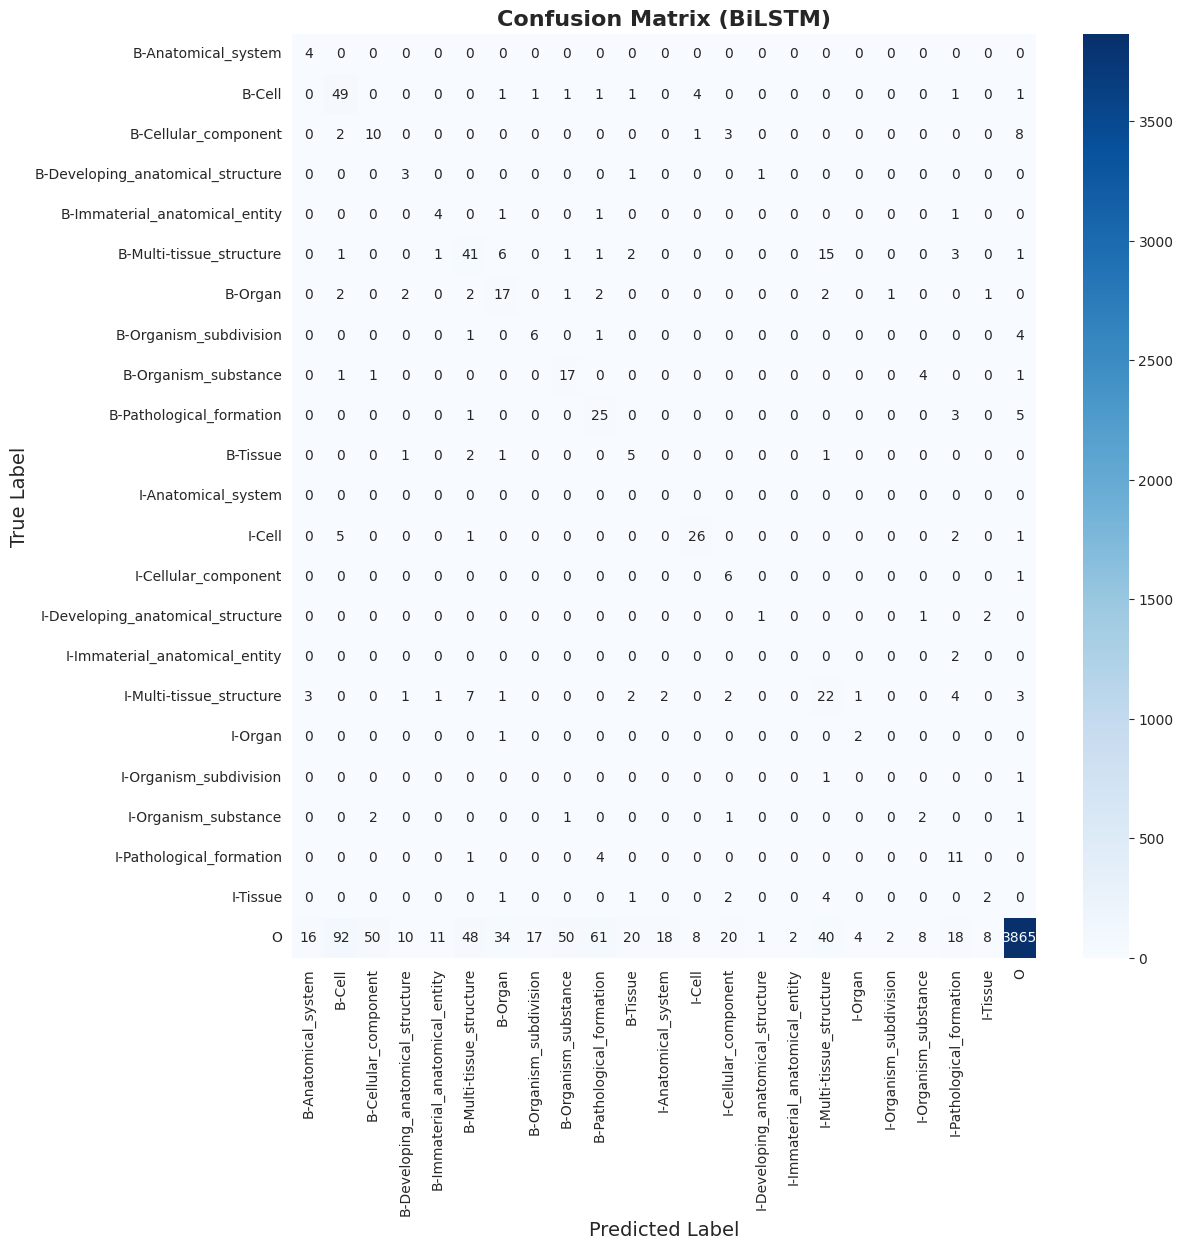

In [ ]:
cm_bilstm = confusion_matrix(y_true_int_bilstm.flatten(), y_pred_int_bilstm.flatten())

plt.figure(figsize=(12,12))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tag_names_bilstm,
            yticklabels=tag_names_bilstm)
plt.title('Confusion Matrix (BiLSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()


##Prediction
In this phase, **we analyze test sequences by comparing the original tokens, true labels, and predicted labels**. This qualitative evaluation helps identify specific strengths and weaknesses of the model.
In the first example, the model correctly identifies entities like 'B-Pathological_formation' and 'B-Organ' but struggles with boundary distinctions, confusing 'B-Pathological_formation' with 'I-Pathological_formation'. In subsequent examples, where most tokens belong to the majority class 'O', the model performs well, showcasing strong classification capabilities for well-represented classes. However, errors such as predicting 'B-Cellular_component' instead of 'O' in example 4 reveal challenges in handling less frequent or ambiguous entities.
This qualitative evaluation complements the metrics by offering insights into the model's behavior and highlighting areas to improve predictions for challenging or rare classes.

In [ ]:
def decode_tokens_bilstm(sequence, tokenizer):
    # Ignora i padding (ID = 0)
    return [tokenizer.index_word[idx] for idx in sequence if idx != 0]

# Previsione sul test set
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_int_bilstm = np.argmax(y_pred_bilstm, axis=-1)   # (num_seq, max_seq_len)
y_true_int_bilstm = np.argmax(y_test, axis=-1)   # (num_seq, max_seq_len)

tag_names_bilstm = label_encoder.classes_

# Mostriamo le prime 5 sequenze di test
for i in range(5):
    tokens_bilstm = decode_tokens_bilstm(X_test[i], tokenizer)
    # Prendiamo la lunghezza effettiva della sequenza (senza padding)
    seq_len_bilstm = len(tokens_bilstm)

    # Convertiamo le etichette vere e predette in formato testuale
    true_labels_bilstm = [tag_names_bilstm[label_id] for label_id in y_true_int_bilstm[i][:seq_len_bilstm]]
    pred_labels_bilstm = [tag_names_bilstm[label_id] for label_id in y_pred_int_bilstm[i][:seq_len_bilstm]]

    print("Sequence:", i+1)
    print("Tokens: ", tokens_bilstm)
    print("True:   ", true_labels_bilstm)
    print("Pred:   ", pred_labels_bilstm)
    print("\n")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sequence: 1
Tokens:  ['lobular', 'sinuses', 'associated', 'generalized', 'inflammatory', 'response', 'intrahepatic', 'portal', 'sinusoid', 'congestion']
True:    ['I-Multi-tissue_structure', 'I-Multi-tissue_structure', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['I-Pathological_formation', 'B-Multi-tissue_structure', 'O', 'O', 'O', 'O', 'B-Multi-tissue_structure', 'B-Multi-tissue_structure', 'I-Multi-tissue_structure', 'I-Multi-tissue_structure']


Sequence: 2
Tokens:  ['identities', 'generations', '12', 'processing', 'industries', 'successful', 'manufacturing', 'marketing', 'jarred', 'baby']
True:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organ', 'O']


Sequence: 3
Tokens:  ['comparison', 'serum', 'ast', 'alt', 'levels', 'ire1alpha', 'cko', 'mice', 'control', 'mice']
True:    ['O', 'B-Organism_substance', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'B-Organism_subs

#GRU (Gated Recurrent Unit)
The Gated Recurrent Unit (GRU) is a recurrent neural network architecture **similar to LSTM but with a simplified structure**. GRUs combine the input and **forget gates into a single update gate**, reducing the number of parameters and computational time. This makes GRUs faster and more efficient, particularly suitable for scenarios where computational resources are limited or datasets are smaller.
The overall structure of this model is similar to the LSTM, with the key difference being the **GRU layer**, which processes sequential data while retaining relevant context. Pre-trained **GloVe embeddings** are used for token representation, and a final** Dense layer** with softmax activation outputs the classification probabilities. Additionally, a custom weighted loss function addresses class imbalance, ensuring better performance across all categories.

##Class weights and weighted  Crossentropy Loss
As with previous models, a weighted loss function was defined to assign greater importance to underrepresented classes. The weights, computed based on class distribution, scale the loss for each token, encouraging the model to improve predictions for minority classes.

In [ ]:
# Convertiamo class_weights_dict in un tensore
class_weights_tensor_gru = tf.constant(
    [class_weights_dict[i] for i in range(num_classes)],
    dtype=tf.float32
)

def weighted_categorical_crossentropy_gru(y_true, y_pred):

    # Calcoliamo la crossentropia standard per ogni token
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # cce: shape (batch, timesteps)

    # Ricaviamo la classe vera per ogni token
    y_true_classes = tf.argmax(y_true, axis=-1)  # shape (batch, timesteps)

    # Otteniamo i pesi per ogni token in base alla classe vera
    token_weights = tf.gather(class_weights_tensor_gru, y_true_classes)  # shape (batch, timesteps)

    # Moltiplichiamo la loss di ogni token per il corrispondente peso
    weighted_loss = cce * tf.cast(token_weights, tf.float32)

    # Ritorniamo la media della loss sul batch
    return tf.reduce_mean(weighted_loss)


In [ ]:
vocab_size_gru = embedding_matrix_lstm.shape[0]
embedding_dim_gru = embedding_matrix_lstm.shape[1]
max_sequence_len_gru = X_train.shape[1]

num_units = 50
# num_classes già definito in precedenza come len(label_encoder.classes_)

model_gru = Sequential()
model_gru.add(Input(shape=(max_sequence_len,)))
model_gru.add(Embedding(
    input_dim=vocab_size_gru,
    output_dim=embedding_dim_gru,
    weights=[embedding_matrix_lstm],
    input_length=max_sequence_len_gru,
    mask_zero=True,
    trainable=True
))
model_gru.add(GRU(units=num_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_gru.add(Dense(num_classes, activation='softmax'))

model_gru.compile(loss=weighted_categorical_crossentropy_gru, optimizer='adam', metrics=['accuracy'])
model_gru.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 10, 100)             │       1,152,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 10, 50)              │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10, 23)              │           1,173 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,175,973 (4.49 MB)

 Trainable params: 1,175,973 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

##Early stopping, ModelCheckpoint and Training
The GRU model was trained for 20 epochs with a batch size of 32, utilizing early stopping to prevent overfitting and **ModelCheckpoint** to save the best model based on validation loss. During training, the model exhibited a steady reduction in loss and an increase in accuracy, achieving a minimum validation **loss of 0.93399**  and a validation **accuracy of 87.1%** at epoch 11, where early stopping terminated the process.

In [ ]:
best_model_file_gru = 'GRU-best-model-with-class-weights.keras'

checkpoint_gru = ModelCheckpoint(
    best_model_file_gru,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_gru = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_gru, early_stopping_gru]
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0347 - loss: 2.9144
Epoch 1: val_loss improved from inf to 2.22455, saving model to GRU-best-model-with-class-weights.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.0352 - loss: 2.9165 - val_accuracy: 0.1979 - val_loss: 2.2245
Epoch 2/20
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2291 - loss: 2.4981
Epoch 2: val_loss improved from 2.22455 to 1.92193, saving model to GRU-best-model-with-class-weights.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2307 - loss: 2.5024 - val_accuracy: 0.4605 - val_loss: 1.9219
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4230 - loss: 2.5125
Epoch 3: val_loss improved from 1.92193 to 1.67921, saving model to GRU-best-model-with-class-weights.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4233 - loss: 2.5096 - val_accuracy: 0.5983 - val_loss: 1.6792
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5755 - loss:

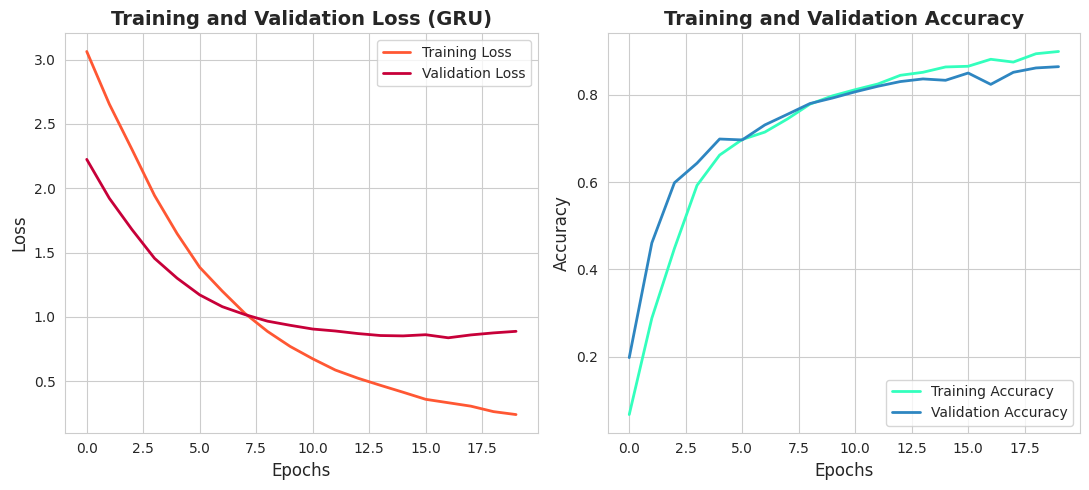

In [ ]:
sns.set_style("whitegrid")

train_color_loss = '#FF5733'
val_color_loss = '#C70039'
train_color_acc = '#33FFBD'
val_color_acc = '#2E86C1'

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Andamento Loss
axes[0].plot(history_gru.history['loss'], label='Training Loss', color=train_color_loss, linewidth=2)
axes[0].plot(history_gru.history['val_loss'], label='Validation Loss', color=val_color_loss, linewidth=2)
axes[0].set_title('Training and Validation Loss (GRU)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

# Andamento Accuracy
axes[1].plot(history_gru.history['accuracy'], label='Training Accuracy', color=train_color_acc, linewidth=2)
axes[1].plot(history_gru.history['val_accuracy'], label='Validation Accuracy', color=val_color_acc, linewidth=2)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


##Evaluation
The GRU model achieved an overall **accuracy of 84.94%** on the test set, demonstrating strong performance in predicting majority classes such as 'O,' which attained an F1-score of 0.93. This indicates the model’s ability to identify tokens that do not belong to any specific entity. For moderately represented classes, such as 'B-Organ' and 'B-Multi-tissue_structure,' the F1-scores of 0.61 and 0.44 highlight the GRU’s capacity to capture relevant patterns, albeit with room for improvement in precision and recall.
However, the model struggled with underrepresented classes like 'I-Developing_anatomical_structure,' where no true positives were recorded, leading to an F1-score of 0.0. This underscores the persistent challenge of handling rare categories effectively, even with the inclusion of a weighted loss function.
Overall, the GRU model balances computational efficiency with robust performance on majority and moderately frequent classes but continues to face limitations in recognizing rare or complex patterns.

In [ ]:
y_pred_gru = model_gru.predict(X_test)
y_pred_int_gru = y_pred_gru.argmax(axis=-1)
y_true_int_gru = y_test.argmax(axis=-1)

tag_names_gru = label_encoder.classes_

accuracy_gru = accuracy_score(y_true_int_gru.flatten(), y_pred_int_gru.flatten())
print(f"Test Accuracy (GRU): {round(accuracy_gru * 100, 2)}%\n")

report_gru= classification_report(y_true_int_gru.flatten(), y_pred_int_gru.flatten(), target_names=tag_names_gru)
print(report_gru)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Test Accuracy (GRU): 82.59%

                                   precision    recall  f1-score   support

              B-Anatomical_system       0.09      1.00      0.16         4
                           B-Cell       0.48      0.73      0.58        60
             B-Cellular_component       0.16      0.71      0.26        24
B-Developing_anatomical_structure       0.13      0.60      0.21         5
   B-Immaterial_anatomical_entity       0.19      0.57      0.29         7
         B-Multi-tissue_structure       0.36      0.51      0.42        72
                          B-Organ       0.50      0.63      0.56        30
           B-Organism_subdivision       0.11      0.50      0.18        12
             B-Organism_substance       0.26      0.67      0.38        24
         B-Pathological_formation       0.18      0.74      0.29        34
                         B-Tissue       0.17      0.70      0.27        10
              I-Anatomical_sys

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


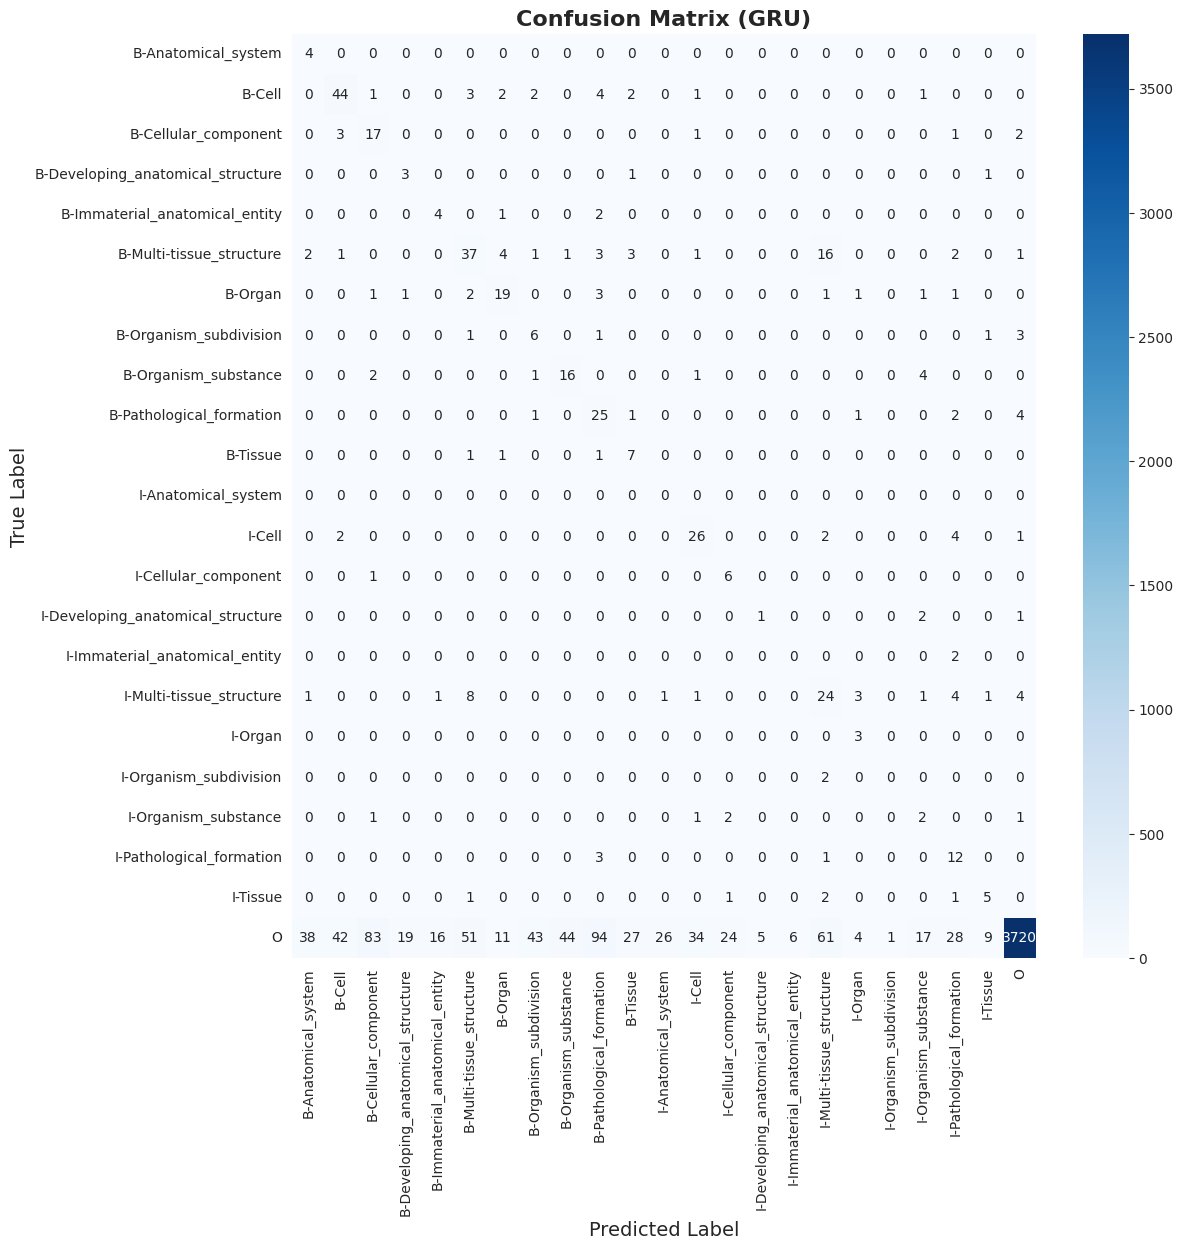

In [ ]:
# Creiamo la confusion matrix
cm_gru = confusion_matrix(y_true_int_gru.flatten(), y_pred_int_gru.flatten())

plt.figure(figsize=(12,12))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues',
            xticklabels=tag_names_gru, yticklabels=tag_names_gru)
plt.title('Confusion Matrix (GRU)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()


##Predictions
By examining the GRU model's predictions on specific test sequences, we observe both strengths and challenges. The** model performs well with majority classes**, such as correctly identifying entities like "brain" as B-Organ and "tissues" as B-Tissue, showcasing its ability to classify well-represented entities. However, **it struggles with maintaining consistency within sequences and occasionally misclassifies surrounding tokens.**

Additionally, the GRU model sometimes predicts entities for irrelevant terms (e.g., labeling "steric" as part of a cellular component), reflecting difficulties in distinguishing subtle differences between domain-specific terminology and unrelated tokens. These errors are particularly noticeable with ambiguous or rare entities, revealing the **model’s limitations in handling underrepresented classes**.

In [ ]:
def decode_tokens_gru(sequence, tokenizer):
    return [tokenizer.index_word[idx] for idx in sequence if idx != 0]

for i in range(5):
    tokens_gru = decode_tokens_gru(X_test[i], tokenizer)
    seq_len_gru = len(tokens_gru)

    true_labels_gru = [tag_names_gru[lid] for lid in y_true_int_gru[i][:seq_len_gru]]
    pred_labels_gru = [tag_names_gru[lid] for lid in y_pred_int_gru[i][:seq_len_gru]]

    print("Sequence:", i+1)
    print("Tokens: ", tokens_gru)
    print("True:   ", true_labels_gru)
    print("Pred:   ", pred_labels_gru)
    print("\n")


Sequence: 1
Tokens:  ['lobular', 'sinuses', 'associated', 'generalized', 'inflammatory', 'response', 'intrahepatic', 'portal', 'sinusoid', 'congestion']
True:    ['I-Multi-tissue_structure', 'I-Multi-tissue_structure', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['I-Pathological_formation', 'B-Immaterial_anatomical_entity', 'I-Multi-tissue_structure', 'O', 'B-Cell', 'O', 'B-Multi-tissue_structure', 'I-Multi-tissue_structure', 'I-Organism_substance', 'O']


Sequence: 2
Tokens:  ['identities', 'generations', '12', 'processing', 'industries', 'successful', 'manufacturing', 'marketing', 'jarred', 'baby']
True:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sequence: 3
Tokens:  ['comparison', 'serum', 'ast', 'alt', 'levels', 'ire1alpha', 'cko', 'mice', 'control', 'mice']
True:    ['O', 'B-Organism_substance', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred:    ['O', 'B-Organism_substance', 'B-Cell', 'B-Organism_substance

# Considerations

**Despite its advantages in computational efficiency, the GRU still faces challenges with underrepresented classes, much like other models.** While it performs well with majority classes like 'O', it struggles with rarer entities, such as 'I-Developing_anatomical_structure', where precision and recall are low.

**In contrast, the BiLSTM has a clear advantage in our case, as its ability to process sequences in both directions helps it capture more complex relationships between tokens.** This gives the BiLSTM an edge in handling mid-represented classes (e.g., 'B-Organ', 'I-Cell') more effectively, offering a deeper contextual understanding that the GRU lacks.

In summary, while the GRU is faster and more efficient, the BiLSTM performs better for our task, particularly when dealing with complex or underrepresented classes.

#Model comparisons
In the comparison between models, we observed that although BiLSTM achieved the best accuracy (84.8%), the improvement was not consistent across all metrics, especially for underrepresented classes. Here's a summary of the main results:

* **LinearSVC** showed an accuracy of 77%, but a low F1 score macro (0.46), indicating that while it performed well on the majority classes, it struggled to identify minority classes. The macro precision (0.69) suggests good performance for the main classes, but the model still has room for improvement.

* **LSTM** achieved an accuracy of 67.5%, with a very low F1 score macro (0.23). Although this model was capable of capturing sequential dependencies, it struggled with the class imbalance, showing low recall (0.37) and poor precision for minority classes.

* **BiLSTM** improved the F1 score macro (0.34), with a higher recall than LSTM (0.67), but was still affected by class imbalance. The macro precision was low (0.25), reflecting difficulty in recognizing rare classes. However, its ability to process bidirectional context allowed it to improve performance for mid-represented classes such as 'B-Organ' and 'I-Cell'.

* **GRU** had a similar accuracy to BiLSTM (84.9%) but with a lower F1 score macro (0.31). While faster and computationally more efficient, it had similar performance in recognizing dominant classes but struggled with minority ones. The recall (0.65) was better than LSTM, but it did not capture context as deeply as the BiLSTM.

**Final Thoughts**:

In summary, **BiLSTM performed better in handling mid-represented classes, but no model managed to handle minority classes well, especially those with zero precision (like 'I-Developing_anatomical_structure').** GRU, while faster and computationally efficient, did not capture contextual relationships as effectively as BiLSTM, which proved to be more suitable for complex tasks.

That being said, none of the models delivered ideal results, and we need to address the issues with minority class recognition. Moving forward, we will focus on improving performance for these rare categories through the exploration of transformers.

In [ ]:
# Metrics for Multi-Label Classification
accuracy_lsvc = metrics.accuracy_score(y_test_multi, predictions_multi)  # Exact Match Accuracy
f1_score_macro_lsvc = metrics.f1_score(y_test_multi, predictions_multi, average='macro')
precision_macro_lsvc = metrics.precision_score(y_test_multi, predictions_multi, average='macro', zero_division=0)
recall_macro_lsvc = metrics.recall_score(y_test_multi, predictions_multi, average='macro', zero_division=0)

# Assicurati che i dati siano array NumPy
y_test_decoded_lstm_np = np.array([item for sublist in y_test_decoded_lstm for item in sublist])
y_pred_test_decoded_lstm_np = np.array([item for sublist in y_pred_test_decoded_lstm for item in sublist])

y_true_int_bilstm_np = np.array(y_true_int_bilstm).flatten()
y_pred_int_bilstm_np = np.array(y_pred_int_bilstm).flatten()

y_true_int_gru_np = np.array(y_true_int_gru).flatten()
y_pred_int_gru_np = np.array(y_pred_int_gru).flatten()

# Compute the F1 score macro average for the 3 models
f1_score_macro_lstm = metrics.f1_score(y_test_decoded_lstm_np, y_pred_test_decoded_lstm_np, average='macro', zero_division=0)
f1_score_macro_bilstm = metrics.f1_score(y_true_int_bilstm_np, y_pred_int_bilstm_np, average='macro', zero_division=0)
f1_score_macro_gru = metrics.f1_score(y_true_int_gru_np, y_pred_int_gru_np, average='macro', zero_division=0)

# Compute the Recall macro average for the 3 models
recall_macro_lstm = metrics.recall_score(y_test_decoded_lstm_np, y_pred_test_decoded_lstm_np, average='macro', zero_division=0)
recall_macro_bilstm = metrics.recall_score(y_true_int_bilstm_np, y_pred_int_bilstm_np, average='macro', zero_division=0)
recall_macro_gru = metrics.recall_score(y_true_int_gru_np, y_pred_int_gru_np, average='macro', zero_division=0)

# Compute the Precision macro average for the 3 models
precision_macro_lstm = metrics.precision_score(y_test_decoded_lstm_np, y_pred_test_decoded_lstm_np, average='macro', zero_division=0)
precision_macro_bilstm = metrics.precision_score(y_true_int_bilstm_np, y_pred_int_bilstm_np, average='macro', zero_division=0)
precision_macro_gru = metrics.precision_score(y_true_int_gru_np, y_pred_int_gru_np, average='macro', zero_division=0)

# Make a table for an overview of the performances
data = {
    'Metric': ['Accuracy', 'F1 Score Macro', 'Recall Macro', 'Precision Macro'],
    'Linear SVC': [accuracy_lsvc, f1_score_macro_lsvc, recall_macro_lsvc, precision_macro_lsvc],
    'LSTM': [test_accuracy_lstm, f1_score_macro_lstm, recall_macro_lstm, precision_macro_lstm],
    'BiLSTM': [accuracy_bilstm, f1_score_macro_bilstm, recall_macro_bilstm, precision_macro_bilstm],
    'GRU': [accuracy_gru, f1_score_macro_gru, recall_macro_gru, precision_macro_gru]
}

evaluation_tab = pd.DataFrame(data)
evaluation_tab_transposed = evaluation_tab.set_index('Metric').T

# Visualizziamo la tabella
display(evaluation_tab_transposed)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metric,Accuracy,F1 Score Macro,Recall Macro,Precision Macro
Linear SVC,0.709544,0.334251,0.260778,0.576734
LSTM,0.678631,0.158554,0.337315,0.129227
BiLSTM,0.854357,0.321638,0.521790,0.255767
GRU,0.825934,0.306784,0.568812,0.235491
